# **Recurrent Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [6]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [7]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [8]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [9]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [10]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [11]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **RNN Model**

In [26]:
def build_model(audio_features,
                learning_rate=0.0001,
                lstm_units=256,
                hidden_layers=[128, 64, 64],
                dropout_rate = 0.3
                ):

    tf.keras.backend.clear_session()

    # Input layer
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2]), name='Audio_Features')

    x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Second LSTM layer
    x = tf.keras.layers.LSTM(lstm_units)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Fully connected layers
    for units in hidden_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=20, activation='softmax')(x)

    # Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    print(model.summary())

    return model


In [34]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_LSTM.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [15]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [16]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [17]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma']), axis=1)

print(training_features.shape)

(5278, 160, 259)


In [18]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma']), axis=1)

print(validation_features.shape)

(1350, 160, 259)


In [27]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 160, 259)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 160, 256)            │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,103,380 (4.21 MB)

 Trainable params: 1,101,844 (4.20 MB)

 Non-trainable params: 1,536 (6.00 KB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.0633 - loss: 34.6656 - val_accuracy: 0.2030 - val_loss: 30.5688
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1435 - loss: 29.9001 - val_accuracy: 0.2230 - val_loss: 26.6399
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1979 - loss: 25.9553 - val_accuracy: 0.2659 - val_loss: 23.0036
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2126 - loss: 22.5282 - val_accuracy: 0.3333 - val_loss: 19.8787
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2444 - loss: 19.5131 - val_accuracy: 0.2933 - val_loss: 17.2677
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2612 - loss: 16.8795 - val_accuracy: 0.3415 - val_loss: 14.9046
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2792 - loss: 14.5833 - val_accuracy: 0.3489 - val_loss: 12.9577
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2884 - los

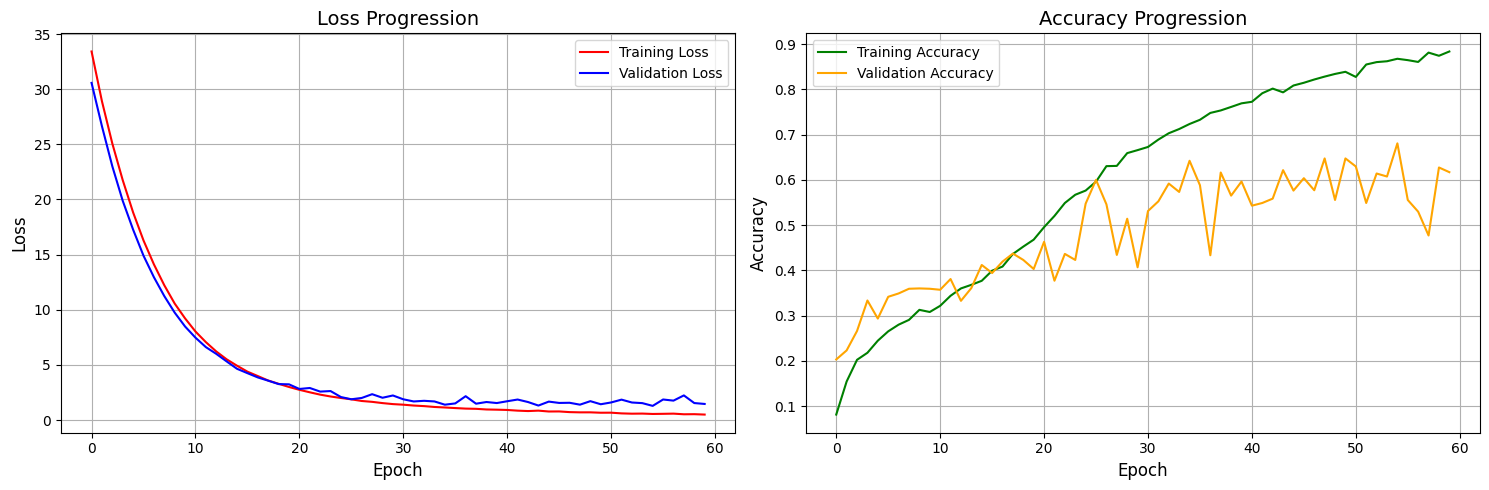

In [28]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [29]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8183 - loss: 0.6650
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6214 - loss: 1.4695


In [30]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       114
           1       0.49      0.28      0.35       141
           2       0.65      0.80      0.72       271
           3       0.67      0.94      0.79        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.13      0.26      0.17        23
           7       0.96      0.98      0.97        44
           8       0.35      0.90      0.51        50
           9       0.86      0.51      0.64        49
          10       0.87      0.81      0.84        48
          11       0.90      0.41      0.57        46
          12       0.80      0.22      0.35        54
          13       0.44      0.62      0.52        48
          14       0.50      0.26      0.34        38
          15       0.39      0.50      0.44       117
          16       1.00      0.64      0.78   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram and MFCCs

In [31]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)

print(training_features.shape)

(5278, 148, 259)


In [32]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)

print(validation_features.shape)

(1350, 148, 259)


In [35]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 148, 259)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 148, 256)            │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,103,380 (4.21 MB)

 Trainable params: 1,101,844 (4.20 MB)

 Non-trainable params: 1,536 (6.00 KB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.0776 - loss: 34.6275 - val_accuracy: 0.0363 - val_loss: 30.5959
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1333 - loss: 29.5110 - val_accuracy: 0.0867 - val_loss: 26.8508
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2121 - loss: 25.1759 - val_accuracy: 0.0652 - val_loss: 22.7150
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2691 - loss: 21.5047 - val_accuracy: 0.1393 - val_loss: 20.6229
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3170 - loss: 18.3418 - val_accuracy: 0.3111 - val_loss: 16.7717
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3386 - loss: 15.6698 - val_accuracy: 0.3393 - val_loss: 14.1230
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3696 - loss: 13.4232 - val_accuracy: 0.2030 - val_loss: 12.8312
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3888 - los

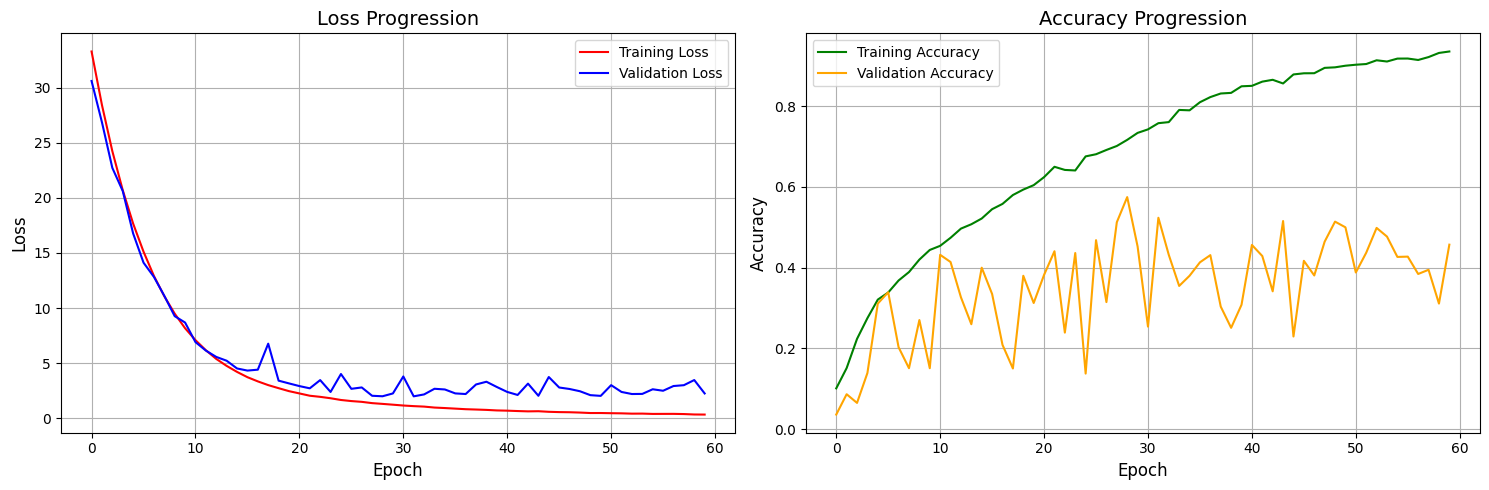

In [36]:
visualize(history, 'mfcc_melspectrogram')

In [37]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7265 - loss: 0.9201
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4576 - loss: 2.2710


In [38]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       114
           1       0.31      0.61      0.41       141
           2       0.69      0.34      0.46       271
           3       0.94      0.56      0.70        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.13      0.17      0.15        23
           7       1.00      0.43      0.60        44
           8       1.00      0.02      0.04        50
           9       0.97      0.59      0.73        49
          10       0.16      0.54      0.25        48
          11       0.31      0.76      0.44        46
          12       0.80      0.37      0.51        54
          13       0.78      0.29      0.42        48
          14       0.64      0.61      0.62        38
          15       0.43      0.09      0.14       117
          16       0.97      0.71      0.82   

### With Mel Spectrogram

In [39]:
# Train features
target_size = 128
training_features = train_features['melspectrogram']
print(training_features.shape)

(5278, 128, 259)


In [40]:
# Validation Features
validation_features = val_features['melspectrogram']

print(validation_features.shape)

(1350, 128, 259)


In [41]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=60,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128, 256)            │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,103,380 (4.21 MB)

 Trainable params: 1,101,844 (4.20 MB)

 Non-trainable params: 1,536 (6.00 KB)

None
Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.0686 - loss: 34.6838 - val_accuracy: 0.0844 - val_loss: 30.7621
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1081 - loss: 30.1110 - val_accuracy: 0.0793 - val_loss: 26.9168
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1535 - loss: 26.1037 - val_accuracy: 0.2274 - val_loss: 23.4010
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2029 - loss: 22.5822 - val_accuracy: 0.2370 - val_loss: 20.6118
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2401 - loss: 19.5714 - val_accuracy: 0.2000 - val_loss: 18.0137
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2638 - loss: 16.9698 - val_accuracy: 0.2141 - val_loss: 15.3750
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2947 - loss: 14.6330 - val_accuracy: 0.1022 - val_loss: 15.1641
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3009 - loss

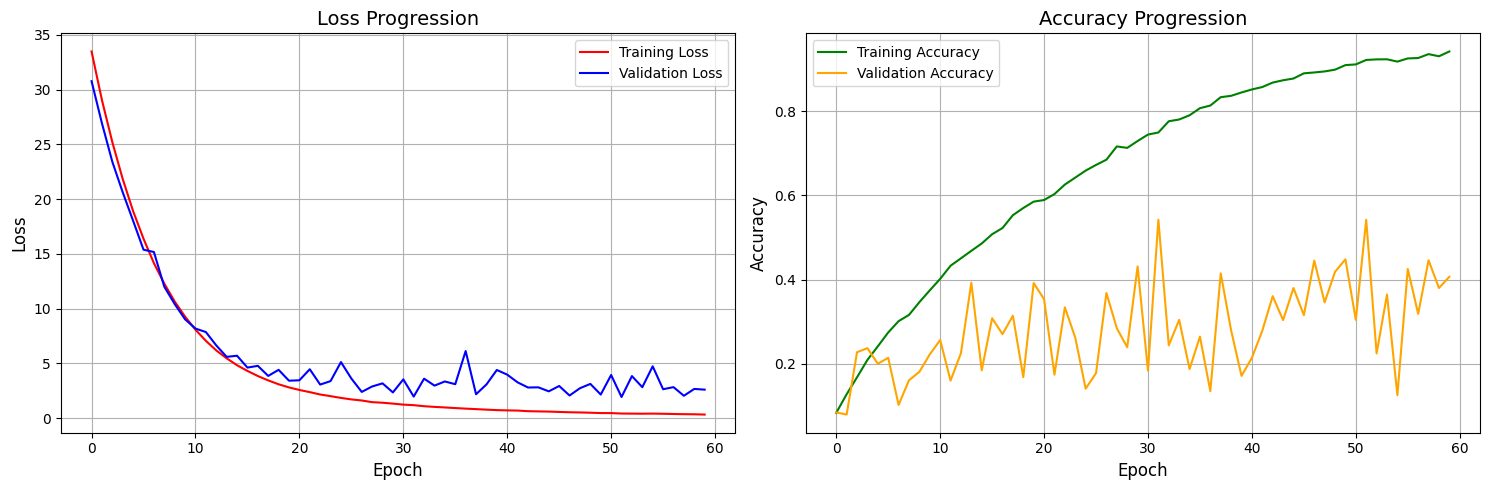

In [42]:
visualize(history, 'melspectrogram')

In [43]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5715 - loss: 1.7299
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4021 - loss: 2.5735


In [44]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.66      0.39      0.49       114
           1       0.27      0.63      0.38       141
           2       0.85      0.34      0.49       271
           3       0.87      0.87      0.87        90
           4       0.00      0.00      0.00        18
           5       0.17      0.07      0.10        15
           6       0.18      0.30      0.23        23
           7       0.00      0.00      0.00        44
           8       0.71      0.10      0.18        50
           9       0.18      0.86      0.29        49
          10       0.50      0.04      0.08        48
          11       0.22      0.67      0.33        46
          12       0.81      0.54      0.64        54
          13       0.28      0.38      0.32        48
          14       0.67      0.21      0.32        38
          15       0.67      0.31      0.42       117
          16       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Review all the results

In [45]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
2,melspectrogram,0.572,0.407
0,melspectrogram_chroma_mfcc,0.811,0.617
1,mfcc_melspectrogram,0.717,0.457


In [46]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
2              melspectrogram     0.404      0.892
0  melspectrogram_chroma_mfcc     0.606      0.945
1         mfcc_melspectrogram     0.465      0.912
